In [2]:
import glob
import os
import h5py
import numpy as np
import torch, monai

from monai.data import ArrayDataset, DataLoader
from monai.transforms import Compose, Rand3DElastic
from monai.utils import first   

from monai.transforms import (
    Compose,
    LoadImage,
    Rand3DElastic,
    RandSpatialCrop,
    ScaleIntensity,
    RandFlip,
    RandRotate90
)
from utils import * # TODO: fix this (change *)
from tqdm import tqdm


In [3]:
monai.utils.set_determinism(10) # Fixes the seed (for reproducibility)
#monai.config.deviceconfig.print_config() # Prints PyTorch GPU information and MONAI dependencies

## Visualize Data

In [4]:
f = h5py.File('datasets/IXI/train/data.mat','r')

print("data_x shape: ", f['data_x'].shape)
print("data_y shape: ", f['data_y'].shape)

t1 = f['data_x'][:,:,20,0] # One slice of t1 (256,256)
t2 = f['data_y'][:,:,20,0] # One slice of t2 (256, 256)

# blended_align = blend_and_transpose(t1, t2) # Blend two images # argparser verbose=True -> image save


data_x shape:  (256, 256, 2275, 3)
data_y shape:  (256, 256, 2275, 3)


In [6]:
test_t1 = f['data_x'][:,:,:,0]
t1_sliced_array = slice_array(test_t1, 91)

t1_sliced_array = t1_sliced_array - np.min(t1_sliced_array, axis=(0,1,2))[None, None, None, :] # make minimum to 0

print(t1_sliced_array.shape) # image data (0, xx) image_data.std() = 1

(256, 256, 91, 25)


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

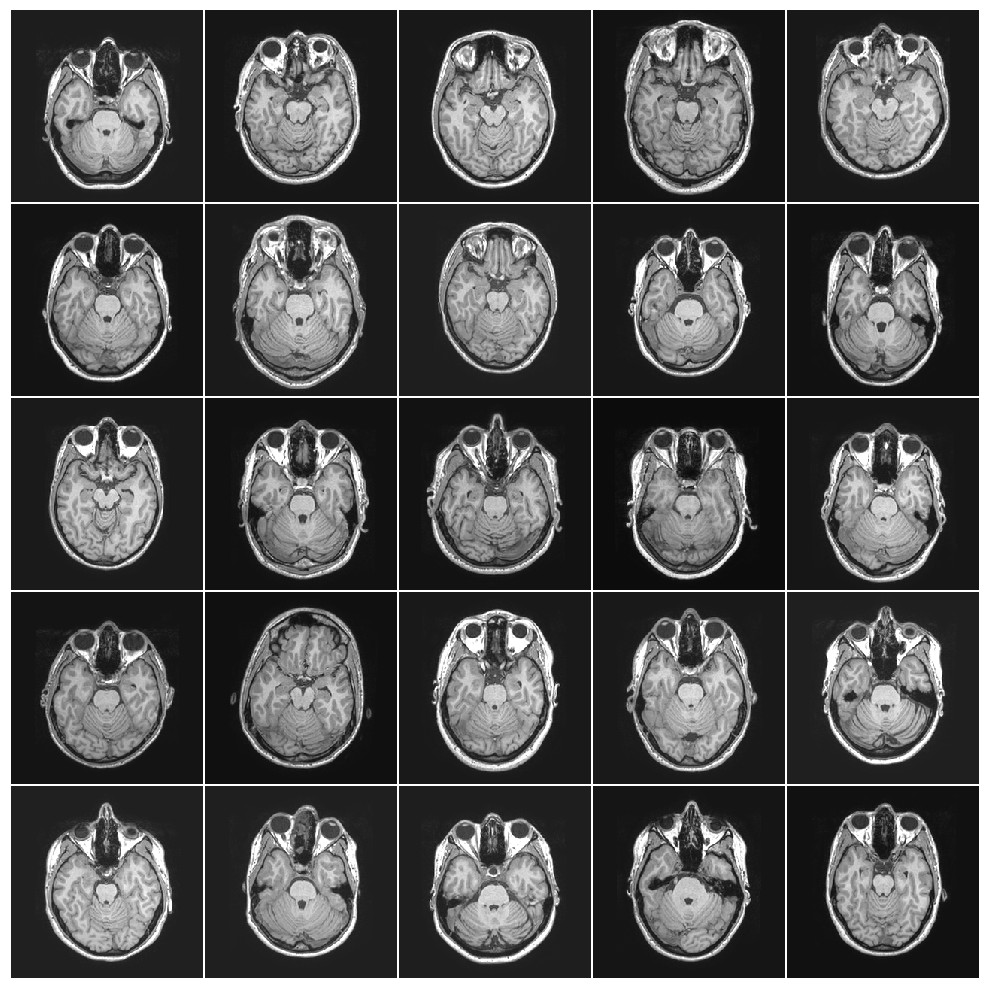

(<Figure size 1000x1000 with 1 Axes>,
 array([[       nan,        nan,        nan, ...,        nan,        nan,
                nan],
        [       nan, 0.06945766, 0.06945766, ..., 0.05784066, 0.05784066,
                nan],
        [       nan, 0.06945766, 0.06945766, ..., 0.05784066, 0.05784066,
                nan],
        ...,
        [       nan, 0.07547373, 0.07547373, ..., 0.03984451, 0.03984451,
                nan],
        [       nan, 0.07547373, 0.07547373, ..., 0.03984451, 0.03984451,
                nan],
        [       nan,        nan,        nan, ...,        nan,        nan,
                nan]], dtype=float32))

In [32]:
matshow3d(test_t1_sliced_array[:,:,20], frame_dim=-1, cmap='gray', show=True, vmin=0, vmax=0.6)

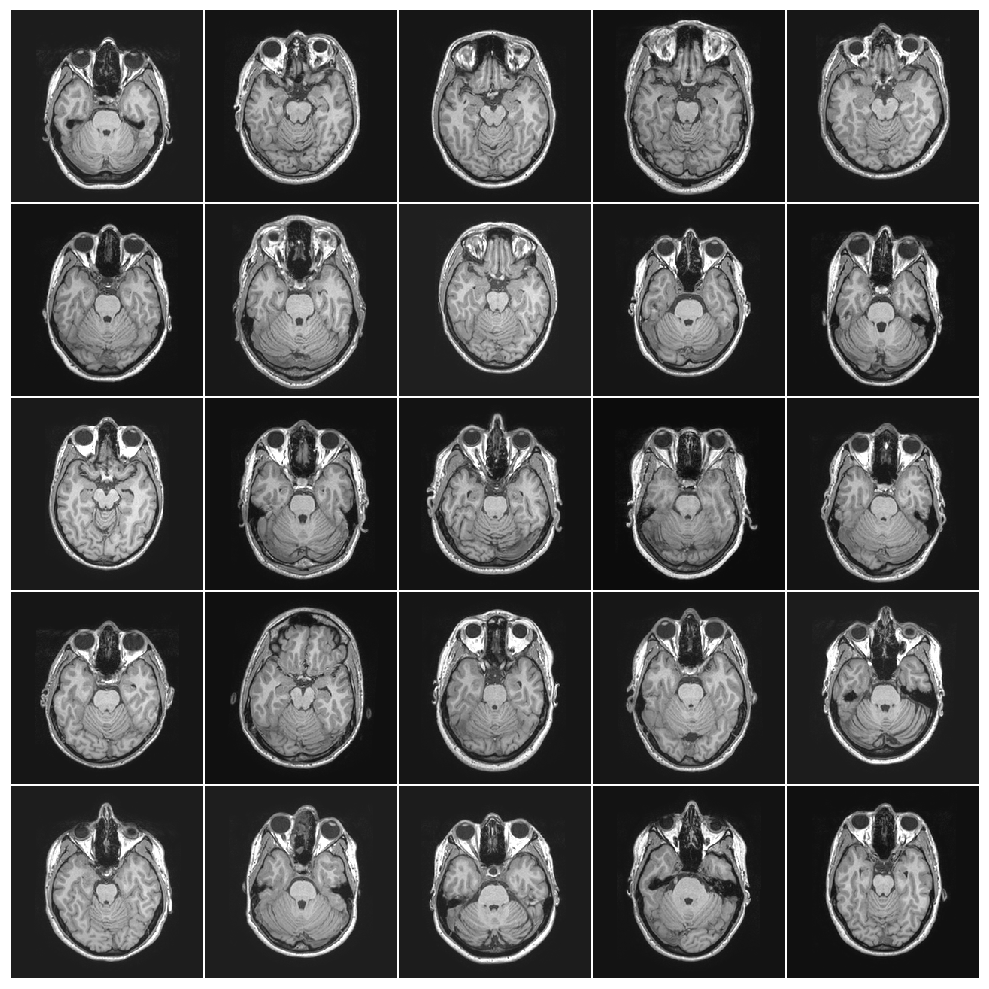

(<Figure size 1000x1000 with 1 Axes>,
 array([[       nan,        nan,        nan, ...,        nan,        nan,
                nan],
        [       nan, 0.4421776 , 0.4421776 , ..., 0.36076403, 0.36076403,
                nan],
        [       nan, 0.4421776 , 0.4421776 , ..., 0.36076403, 0.36076403,
                nan],
        ...,
        [       nan, 0.46182105, 0.46182105, ..., 0.25546408, 0.25546408,
                nan],
        [       nan, 0.46182105, 0.46182105, ..., 0.25546408, 0.25546408,
                nan],
        [       nan,        nan,        nan, ...,        nan,        nan,
                nan]], dtype=float32))

In [25]:
matshow3d(test_test_t1_sliced_array[:,:,20], frame_dim=-1, cmap='gray', show=True, vmin=0, vmax=4)


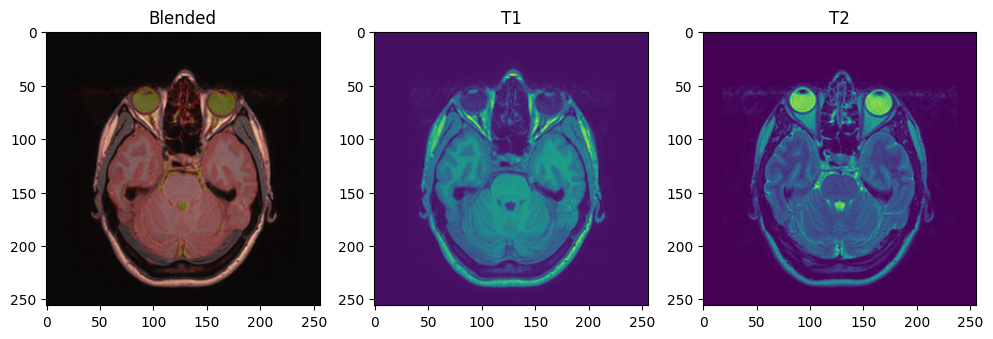

In [4]:
plot_images([blended_align, t1,t2], ['Blended', 'T1', 'T2']) # Plot the images

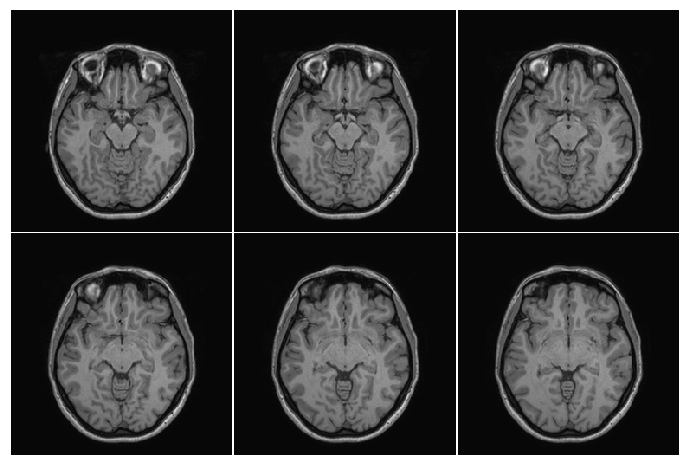

In [5]:
fig = matshow3d(f['data_x'][:,:,30:36,0], frame_dim=-1, show=True, cmap='gray', figsize=(7,7)) # Plot 3D image (multi-slice)

# Preprocessing for Training dataset

## 1. Change `data.mat` to `t1_xx.nii` and `t2_xx.nii` files

- Subject별로 있어서, misalign simulation 하기 편함 (3D translation, etc)

In [8]:
# Load File
f = h5py.File('datasets/IXI/train/data.mat','r')

# Training
# T1
array = f['data_x'][...,0] # first slice in t1
block_size = 91 # 91 slices in one subject
sliced_array = slice_array(array, block_size)
output_prefix = "datasets/IXI/train/t1"
save_slices_to_nii(sliced_array, output_prefix) # See the definition in utils.py file

# T2
array = f['data_y'][...,0]
block_size = 91
sliced_array = slice_array(array, block_size)
output_prefix = "datasets/IXI/train/t2"
save_slices_to_nii(sliced_array, output_prefix)

# Validation
f = h5py.File('datasets/IXI/val/data.mat','r')

# T1
array = f['data_x'][...,0] # first slice in t1
block_size = 91 # 91 slices in one subject
sliced_array = slice_array(array, block_size)
output_prefix = "datasets/IXI/val/t1"
save_slices_to_nii(sliced_array, output_prefix) 

# T2
array = f['data_y'][...,0]
block_size = 91
sliced_array = slice_array(array, block_size)
output_prefix = "datasets/IXI/val/t2"
save_slices_to_nii(sliced_array, output_prefix)

# Testing
f = h5py.File('datasets/IXI/test/data.mat','r')

# T1
array = f['data_x'][...,0] # first slice in t1
block_size = 91 # 91 slices in one subject
sliced_array = slice_array(array, block_size)
output_prefix = "datasets/IXI/test/t1"
save_slices_to_nii(sliced_array, output_prefix) 

# T2
array = f['data_y'][...,0]
block_size = 91
sliced_array = slice_array(array, block_size)
output_prefix = "datasets/IXI/test/t2"
save_slices_to_nii(sliced_array, output_prefix)


## 2. Apply misalignment for each subjects

In [6]:
# This code takes about 17 min to run.

params_list = []
for i in range(1, 2):
    params = {
        "mode": "nearest",
        "prob": 1.0,
        "sigma_range": (0.3 * i, 0.5 * i), # Sigma range for smoothing random displacement
        "magnitude_range": (0.04 * i, 0.04 * i, 0.04 * i), # Deformation magnitude
        "rotate_range": (0.04 * i, 0.04 * i, 0.04 * i),
        "shear_range": (0.01 * i, 0.01 * i, 0.01 * i),
        "translate_range": (1 * i, 1 * i, 1 * i),
        "padding_mode": "border"
    }
    params_list.append(params)

root_dir = 'datasets/IXI/train'
t1s = sorted(glob.glob(os.path.join(root_dir, "t1*.nii.gz")))
t2s = sorted(glob.glob(os.path.join(root_dir, "t2*.nii.gz")))

for param_idx, params in enumerate(params_list):
    
    rand_3d_elastic_transform = Rand3DElastic(**params)
    
    imtrans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
        ]
    )

    imtrans_transformed = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
            rand_3d_elastic_transform # Apply misalign to t1 data
        ]
    )

    segtrans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
            
        ]
    )

    ds = ArrayDataset(t1s, imtrans, t1s, imtrans_transformed, t2s, segtrans)

    loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
    im1, im1_trans, im2 = first(loader)
    print(im1.shape, im1_trans.shape, im2.shape)

    # Save training dataset to numpy array file (Slice by Slice)
    t1_t1_mi = []
    t1_t2_mi = []
    for idx, (im1, im1_trans, im2) in tqdm(enumerate(loader), desc='3d image'):
        nslice = im1.shape[-1]

        for sl in range(nslice):
            t1_align_path = f'datasets/IXI/train/t1_align/t1_{idx}_{sl}.npy'
            t1_misalign_path = f'datasets/IXI/train/t1_misalign_{param_idx}/t1_{idx}_{sl}.npy'
            t2_path = f'datasets/IXI/train/t2/t2_{idx}_{sl}.npy'
            
            t1_align = im1[...,sl].squeeze() # shape: torch.Size([256, 256])
            t1_misalign = im1_trans[...,sl].squeeze()
            t2 = im2[...,sl].squeeze()

            os.makedirs(os.path.dirname(t1_align_path), exist_ok=True)
            os.makedirs(os.path.dirname(t1_misalign_path), exist_ok=True)
            os.makedirs(os.path.dirname(t2_path), exist_ok=True)

            if(param_idx == 0): # Operate only at the first time
                np.save(t1_align_path, t1_align)
                np.save(t2_path, t2)
            np.save(t1_misalign_path, t1_misalign)

            t1_t1_mi.append(calculate_mutual_info(t1_align, t1_misalign))
            t1_t2_mi.append(calculate_mutual_info(t2, t1_misalign)) 
        
    t1_t1_mi = np.array(t1_t1_mi)
    t1_t2_mi = np.array(t1_t2_mi)

    t1_t1_avg, t1_t1_var, t1_t1_std = np.mean(t1_t1_mi), np.var(t1_t1_mi), np.std(t1_t1_mi)
    t1_t2_avg, t1_t2_var, t1_t2_std = np.mean(t1_t2_mi), np.var(t1_t2_mi), np.std(t1_t2_mi)

    mi_path = f'datasets/IXI/train/t1_misalign_{param_idx}/MI_metric.txt'
    os.makedirs(os.path.dirname(mi_path), exist_ok=True)
    with open(mi_path, 'w') as f:
        f.write(f"T1-T1(Misaligned) Mutual Information:\n")
        f.write(f"Average: {t1_t1_avg}\nVariance: {t1_t1_var}\nStandard Deviation: {t1_t1_std}\n\n")
        
        f.write(f"T2-T1(Misaligned) Mutual Information:\n")
        f.write(f"Average: {t1_t2_avg}\nVariance: {t1_t2_var}\nStandard Deviation: {t1_t2_std}\n\n")

        f.write(f"T1-T1 Values: {', '.join(map(str, t1_t1_mi))}\n\n")
        f.write(f"T2-T1 Values: {', '.join(map(str, t1_t2_mi))}\n")

    params_path = f'datasets/IXI/train/t1_misalign_{param_idx}/params.txt'
    os.makedirs(os.path.dirname(params_path), exist_ok=True)
    with open(params_path, 'w') as f:
        for key, value in params.items():
            f.write(f"{key}: {value}\n")

    print("param",param_idx," Done")

/home/kanghyun/miniconda3/envs/misalign/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/home/kanghyun/miniconda3/envs/misalign/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/home/kanghyun/miniconda3/envs/misalign/lib/python3.9/site-packages/monai/data/__init__.py:120: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage

torch.Size([1, 1, 256, 256, 91]) torch.Size([1, 1, 256, 256, 91]) torch.Size([1, 1, 256, 256, 91])


3d image: 25it [00:21,  1.17it/s]

param 0  Done


## 3. Visualize the actual dataset (Patched 96x96)

In [34]:
t1s_dir = 'datasets/IXI/train/t1_misalign_0' # Misaligned data
t2s_dir = 'datasets/IXI/train/t2'

t1s = sorted(glob.glob(os.path.join(t1s_dir, "t1*.npy")))
t2s = sorted(glob.glob(os.path.join(t2s_dir, "t2*.npy")))

t1_trans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
            ScaleIntensity(),
            RandSpatialCrop((64, 64), random_size=False),
            RandFlip(prob=0.5, spatial_axis=0),
            RandFlip(prob=0.5, spatial_axis=1),
            RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        ]
    )

t2_trans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
            ScaleIntensity(),
            RandSpatialCrop((64, 64), random_size=False),
            RandFlip(prob=0.5, spatial_axis=0),
            RandFlip(prob=0.5, spatial_axis=1),
            RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        ]
    )


# define array dataset, data loader
check_ds = ArrayDataset(t1s, t1_trans, t2s, t2_trans)
check_loader = DataLoader(check_ds, batch_size=30, num_workers=2, pin_memory=torch.cuda.is_available())
t1, t2 = monai.utils.misc.first(check_loader)
print(t1.shape, t2.shape)

/home/kanghyun/miniconda3/envs/misalign/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/home/kanghyun/miniconda3/envs/misalign/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/home/kanghyun/miniconda3/envs/misalign/lib/python3.9/site-packages/monai/data/__init__.py:120: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage

torch.Size([30, 1, 64, 64]) torch.Size([30, 1, 64, 64])


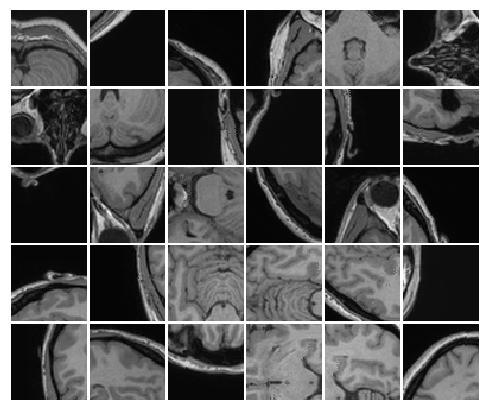

In [35]:
fig = matshow3d(t1, show=True, cmap='gray',figsize=(5,5), vmin=0, vmax=1) #TODO: matshow3d 기능 정리

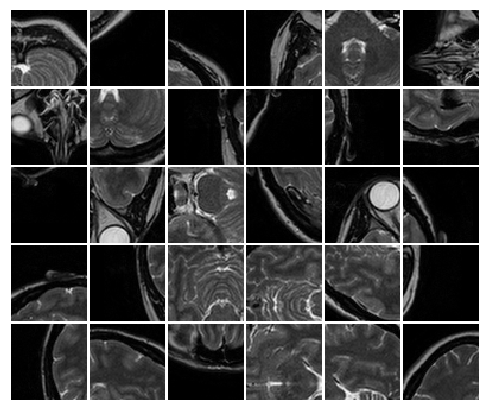

In [36]:
fig = matshow3d(t2, show=True, cmap='gray',figsize=(5,5), vmin=0, vmax=1)

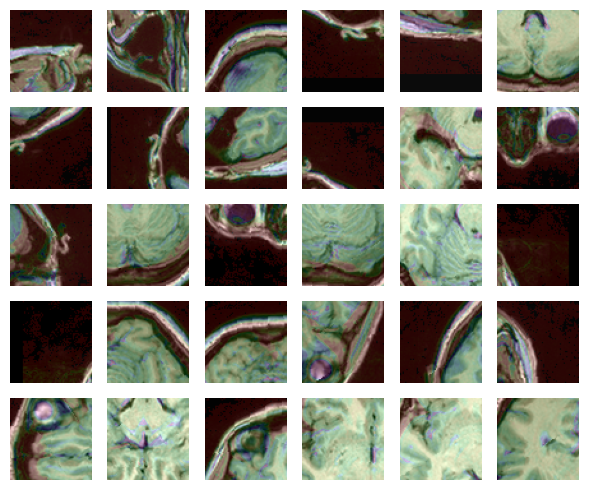

In [34]:
fig = plot_blended_images(t1,t2) # plot blended images (Use this function to plot the blended images of size: torch.Size([30, 1, 64, 64]) torch.Size([30, 1, 64, 64]))

## Process validation and test dataset

- Note: Validation and Test dataset has no misalignment

In [29]:

root_dir = 'datasets/IXI/val'
t1s = sorted(glob.glob(os.path.join(root_dir, "t1*.nii.gz")))
t2s = sorted(glob.glob(os.path.join(root_dir, "t2*.nii.gz")))

imtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
    ]
)

segtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
    ]
)

ds = ArrayDataset(t1s, imtrans, t2s, segtrans)

loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
im1, im2 = first(loader)
print(im1.shape, im2.shape)

# Save training dataset to numpy array file (Slice by Slice)
for idx, (im1, im2) in tqdm(enumerate(loader), desc='3d image'):
    nslice = im1.shape[-1]
    for sl in range(nslice):
        np.save(f'datasets/IXI/val/t1_{idx}_{sl}.npy', im1[...,sl].squeeze())
        np.save(f'datasets/IXI/val/t2_{idx}_{sl}.npy', im2[...,sl].squeeze())
        

torch.Size([1, 1, 256, 256, 91]) torch.Size([1, 1, 256, 256, 91])


3d image: 5it [00:02,  1.71it/s]


In [30]:

root_dir = 'datasets/IXI/test'
t1s = sorted(glob.glob(os.path.join(root_dir, "t1*.nii.gz")))
t2s = sorted(glob.glob(os.path.join(root_dir, "t2*.nii.gz")))

imtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
    ]
)

segtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
    ]
)

ds = ArrayDataset(t1s, imtrans, t2s, segtrans)

loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
im1, im2 = first(loader)
print(im1.shape, im2.shape)

# Save training dataset to numpy array file (Slice by Slice)
for idx, (im1, im2) in tqdm(enumerate(loader), desc='3d image'):
    nslice = im1.shape[-1]
    for sl in range(nslice):
        np.save(f'datasets/IXI/test/t1_{idx}_{sl}.npy', im1[...,sl].squeeze())
        np.save(f'datasets/IXI/test/t2_{idx}_{sl}.npy', im2[...,sl].squeeze())
        

torch.Size([1, 1, 256, 256, 91]) torch.Size([1, 1, 256, 256, 91])


3d image: 10it [00:04,  2.26it/s]


## TODO: make the whole code into a single code (that saves auxilary images)